In [140]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np
import os
import sys
import glob
import requests
import yahist
from yahist import Hist1D
from scipy.integrate import odeint
import scipy.optimize
import scipy.stats
import gzip
from tqdm.auto import tqdm
from utils import fit_exp

In [141]:
yahist.utils.set_default_style()

In [142]:
df_ages = pd.read_json("../sources/manualdeaths/data/df_ages.json")
df_genders = pd.read_json("../sources/manualdeaths/data/df_genders.json")

df_ages["cases"] = df_ages["cases"].astype(int)
df_genders["cases"] = df_genders["cases"].astype(int)
df_ages["deaths"] = df_ages["deaths"].replace("",np.nan).astype(float)
df_genders["deaths"] = df_genders["deaths"].replace("",np.nan).astype(float)

In [143]:
df_ages.head()

,cases,deaths,state,date,age
0,17,NaN,AR,2020-03-31,0-18
1,348,NaN,AR,2020-03-31,19-64
2,158,NaN,AR,2020-03-31,>=65
3,36,NaN,AZ,2020-04-01,5-19
4,517,NaN,AZ,2020-04-01,20-44


In [144]:
df_genders.head()

,gender,cases,deaths,state,date
0,M,209,NaN,AR,2020-03-31
1,F,314,NaN,AR,2020-03-31
2,F,3155,NaN,CA,2020-03-30
3,M,3666,NaN,CA,2020-03-30
4,F,1836,38.0,CT,2020-04-01


In [145]:
df = df_genders.dropna().groupby("gender")[["cases","deaths"]].sum()
df["deaths"] = df["deaths"].astype(int)
df["deaths/cases [%]"] = (100.0*df["deaths"]/df["cases"]).round(2)
df

,cases,deaths,deaths/cases [%]
gender,,,
F,22887,466,2.04
M,22330,643,2.88


In [146]:
data = []
cases_lookup = df_ages.dropna().groupby("state")["cases"].sum()
for i,row in df_ages.dropna().iterrows():
    age = row["age"]
    if "-" in age:
        xlow, xhigh = list(map(int,age.split("-")))
    if ">" in age:
        xlow = int(age.replace(">","").replace("=",""))
        xhigh = max(xlow+5,100)
#     if row["state"] == "MA":
#         print(row)
    data.append(dict(
        xlow=xlow,
        xhigh=xhigh,
        cases=row["cases"],
        deaths=row["deaths"],
        state=row["state"],
        xcenter=0.5*(xlow+xhigh),
    ))
df = pd.DataFrame(data)
df["tot_cases"] = df["state"].map(cases_lookup)
df

,xlow,xhigh,cases,deaths,state,xcenter,tot_cases
0,0,9,29,1.0,CT,4.5,3553
1,10,19,74,0.0,CT,14.5,3553
2,20,29,432,0.0,CT,24.5,3553
3,30,39,560,1.0,CT,34.5,3553
4,40,49,620,4.0,CT,44.5,3553
...,...,...,...,...,...,...,...
87,50,59,295,6.0,WI,54.5,1550
88,60,69,310,5.0,WI,64.5,1550
89,70,79,165,6.0,WI,74.5,1550
90,80,89,77,5.0,WI,84.5,1550


In [147]:
from yahist.utils import clopper_pearson_error
# print(df["deaths"])
low, high = clopper_pearson_error(df["deaths"],df["cases"])
low = np.nan_to_num(low)
# print(low, high)

df["deathrate"] = df["deaths"]/df["cases"]
df["deathratelow"] = low
df["deathratehigh"] = high

In [148]:
df.query("state=='IN'")
# df.query("state=='MA'")

,xlow,xhigh,cases,deaths,state,xcenter,tot_cases,deathrate,deathratelow,deathratehigh
28,0,19,36,0.0,IN,9.5,2566,0.000000,0.000000,0.049855
29,20,29,272,0.0,IN,24.5,2566,0.000000,0.000000,0.006746
30,30,39,367,1.0,IN,34.5,2566,0.002725,0.000471,0.008963
31,40,49,423,0.0,IN,44.5,2566,0.000000,0.000000,0.004343
32,50,59,503,7.0,IN,54.5,2566,0.013917,0.008798,0.021332
33,60,69,449,13.0,IN,64.5,2566,0.028953,0.021088,0.039209
34,70,79,313,20.0,IN,74.5,2566,0.063898,0.050009,0.080889
35,80,100,203,23.0,IN,90.0,2566,0.113300,0.090714,0.140106


Text(0.5, 1.0, 'fraction of cases per unit age')

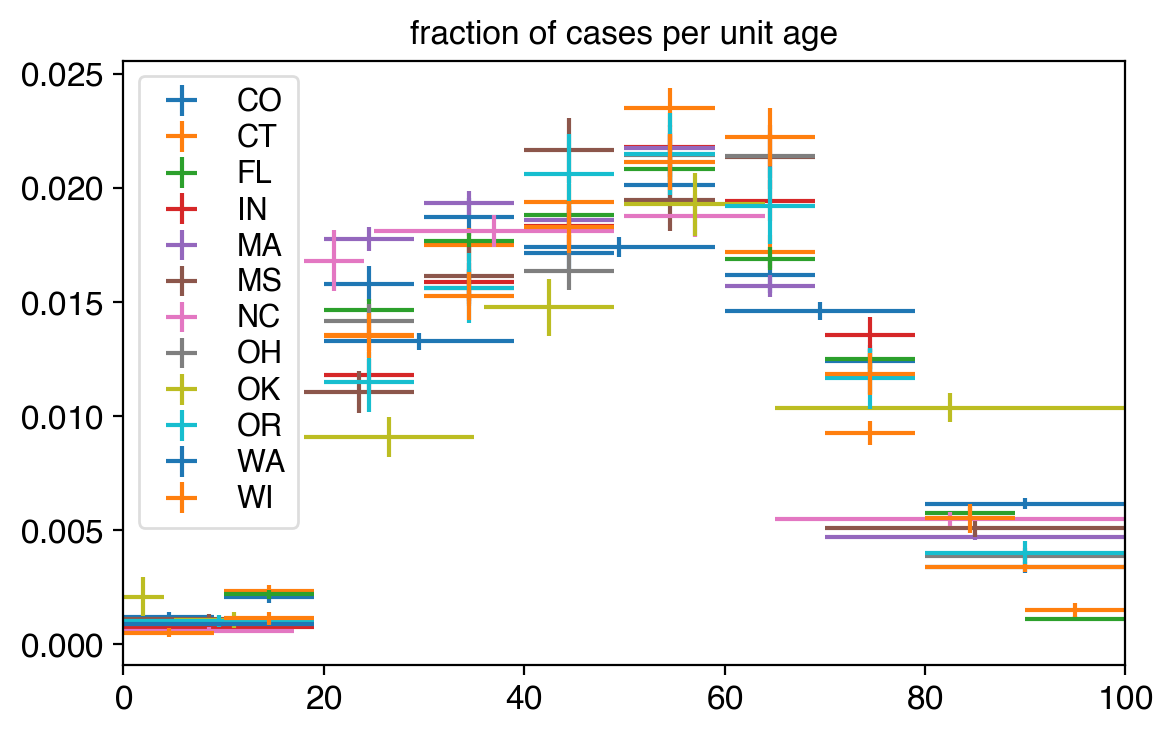

In [157]:
fig, ax = plt.subplots()
for state,group in df.groupby("state"):
    ax.errorbar(
#                 group["xcenter"],group["cases"],
                group["xcenter"],group.eval("cases/(tot_cases*(xhigh-xlow))"),
                xerr=[group["xcenter"]-group["xlow"],group["xhigh"]-group["xcenter"]],
#                 yerr=group["cases"]**0.5,
#                 yerr=group["cases"]**0.5/group["tot_cases"],
                yerr = group.eval("cases**0.5/(tot_cases*(xhigh-xlow))"),
                linestyle="none",
                label=state,
               )


ax.legend()
ax.set_title("fraction of cases per unit age")

Text(0.5, 1.0, 'death rate per unit age')

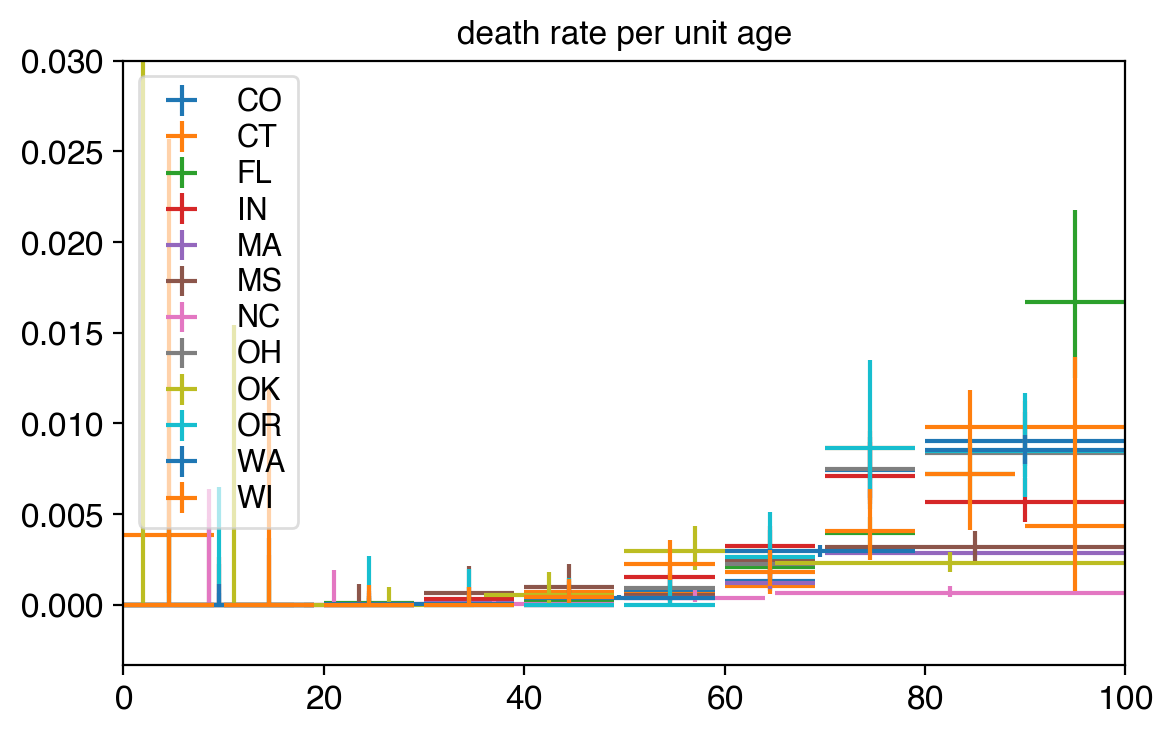

In [161]:
fig, ax = plt.subplots()
for state,group in df.groupby("state"):
    ax.errorbar(
#                 group["xcenter"],group["cases"],
                group["xcenter"],group.eval("deathrate/(xhigh-xlow)"),
                xerr=[group["xcenter"]-group["xlow"],group["xhigh"]-group["xcenter"]],
#                 yerr=group["cases"]**0.5,
#                 yerr=group["cases"]**0.5/group["tot_cases"],
                yerr = [
                    group.eval("(deathrate-deathratelow)/(xhigh-xlow)"),
                    group.eval("(deathratehigh-deathrate)/(xhigh-xlow)"),
                ],
                linestyle="none",
                label=state,
               )


ax.set_ylim(top=0.03)
ax.legend()
ax.set_title("death rate per unit age")

(0.0, 0.27744517046867756)

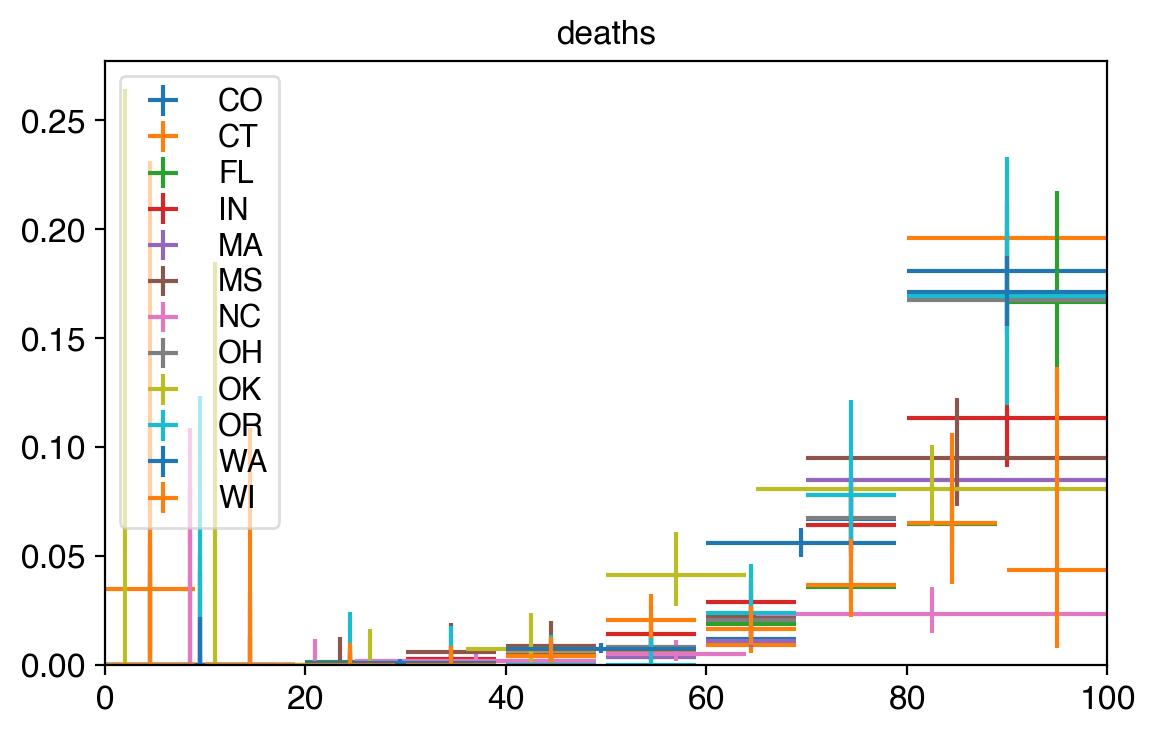

In [151]:

fig, ax = plt.subplots()
for state,group in df.groupby("state"):
#     if state not in ["IN"]: continue
    ax.errorbar(group["xcenter"],group["deathrate"],
                xerr=[group["xcenter"]-group["xlow"],group["xhigh"]-group["xcenter"]],
                yerr=[group["deathrate"]-group["deathratelow"], group["deathratehigh"]-group["deathrate"]],
                linestyle="none",
                label=state,
               )

ax.legend()
ax.set_title("deaths")
ax.set_ylim(bottom=0.)

5.074698871396336e-05 +- 2.249170327357006e-05
0.09011586851921477 +- 0.0058422152600241485
-0.0006346355764984493 +- 0.0004927257445070782
3.752868451033166e-05 +- 3.039380515049052e-06
-0.0027635345837918094 +- 0.00027226212654518064
0.04858690328418634 +- 0.005787142687015133


Text(0.5, 0, 'age')

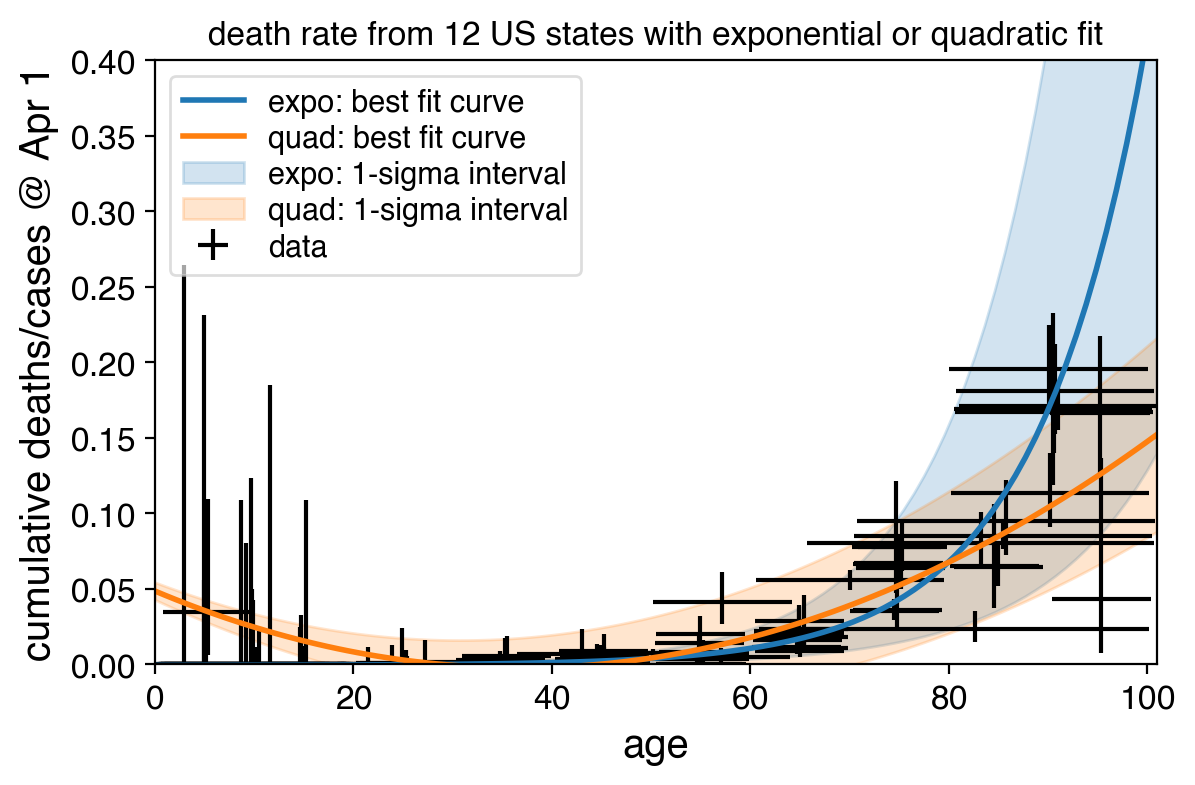

In [156]:
from scipy import odr
import numpy as np
from scipy.optimize import curve_fit
from scipy import odr

dfsub = df
# dfsub = df.query("xcenter>20")

x = dfsub["xcenter"]
y = dfsub["deathrate"]
sx = dfsub["xcenter"]-dfsub["xlow"]
sy = dfsub["deathratehigh"]-dfsub["deathrate"]
syup = dfsub["deathratehigh"]-dfsub["deathrate"]
sydown = dfsub["deathrate"]-dfsub["deathratelow"]

fig, ax = plt.subplots(1)
xjitter = np.random.random(len(x))
plt.errorbar(x+xjitter, y, yerr=[sydown,syup], xerr=sx, hold=True, ecolor='k', fmt='none', label='data')
nstates = df["state"].nunique()
plt.title(f'death rate from {nstates} US states with exponential or quadratic fit')

# Create a RealData object
data = odr.RealData(x, y, sx=sx, sy=sy)

for do_exp in [True, False]:
    if do_exp:
        def func(p, x):
            a, b, c = p
            return a * np.exp(b*x) + c
        out = odr.ODR(data, odr.Model(func), beta0=[0.01, 1./70, 0]).run()
    else:
        def func(p, x):
            a, b, c = p
            return a * x *x + b*x + c
        out = odr.ODR(data, odr.Model(func), beta0=[0., 1., 1.]).run()

    #print fit parameters and 1-sigma estimates
    popt = out.beta
    perr = out.sd_beta
    for i in range(len(popt)):
        print(str(popt[i])+' +- '+str(perr[i]))

    nstd = 1.
    popt_up = popt + nstd * perr
    popt_dw = popt - nstd * perr

    x_fit = np.linspace(min(x-sx), max(x+sx+1), 100)
    fit = func(popt, x_fit)
    fit_up = func(popt_up, x_fit)
    fit_dw= func(popt_dw, x_fit)

    #plot
    if do_exp:
        ax.plot(x_fit, fit, color='C0', lw=2, label='expo: best fit curve')
        ax.fill_between(x_fit, fit_up, fit_dw, color="C0", alpha=.2, label='expo: 1-sigma interval')
    else:
        ax.plot(x_fit, fit, color='C1', lw=2, label='quad: best fit curve')
        ax.fill_between(x_fit, fit_up, fit_dw, color="C1", alpha=.2, label='quad: 1-sigma interval')
    
# ax.legend(loc='top left')
ax.legend()
ax.set_ylim(top=0.4)
ax.set_ylim(bottom=0.)
# ax.set_ylim(bottom=0.001)
# ax.set_yscale("log")
ax.set_ylabel("cumulative deaths/cases @ Apr 1")
ax.set_xlabel("age")

Text(0.5, 1.0, 'fraction of cases per unit age')

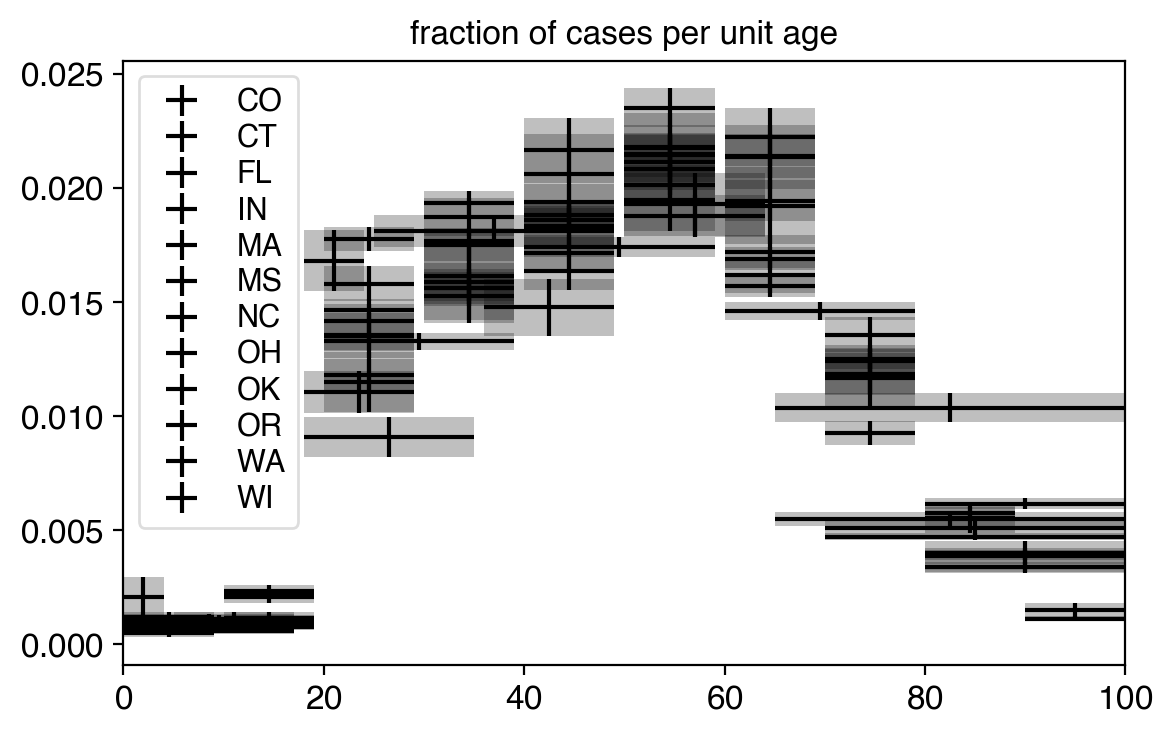

In [174]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

fig, ax = plt.subplots()
for state,group in df.groupby("state"):
    xdata = group["xcenter"]
    ydata = group.eval("cases/(tot_cases*(xhigh-xlow))")
    yerr = group.eval("cases**0.5/(tot_cases*(xhigh-xlow))")
    xerr = group["xcenter"]-group["xlow"]
    ax.errorbar(
                xdata,ydata,
                xerr=xerr,
                yerr = yerr,
                linestyle="none",
                color="k",
                label=state,
               )
    
    # Loop over data points; create box from errors at each point
    errorboxes = []
    for x, y, xe, ye in zip(xdata, ydata, xerr, yerr):
        rect = Rectangle((x - xe, y - ye), xe*2, ye*2)
        errorboxes.append(rect)
    pc = PatchCollection(errorboxes, facecolor="k", alpha=0.25,edgecolor=None)
    ax.add_collection(pc)


ax.legend()
ax.set_title("fraction of cases per unit age")